In [ ]:
if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install

In [ ]:
library(BiocManager)
BiocManager::install('umap')

In [1]:
# load libraries
library(DESeq2)
library(tidyverse)
library(airway)
library(ggplot2)
library(pheatmap)


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

    windows


Loading required package: GenomicRanges

Loading required p

In [6]:
#   Differential expression analysis with limma
library(GEOquery)
library(limma)
library(umap)

In [12]:
# load series and platform data from GEO

gset <- getGEO("GSE67033", GSEMatrix =TRUE, AnnotGPL=FALSE)
if (length(gset) > 1) idx <- grep("GPL16699", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

# make proper column names to match toptable 
fvarLabels(gset) <- make.names(fvarLabels(gset))

# group membership for all samples
gsms <- "0000XXXX1111XXXXXXXXXXXX"
sml <- strsplit(gsms, split="")[[1]]

# filter out excluded samples (marked as "X")
sel <- which(sml != "X")
sml <- sml[sel]
gset <- gset[ ,sel]


Found 1 file(s)

GSE67033_series_matrix.txt.gz

Using locally cached version of GPL16699 found here:
C:\Users\3060\AppData\Local\Temp\RtmpyiPurZ/GPL16699.soft.gz 



In [13]:
gset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 58717 features, 8 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM1636497 GSM1636498 ... GSM1636508 (8 total)
  varLabels: title geo_accession ... tissue:ch1 (38 total)
  varMetadata: labelDescription
featureData
  featureNames: 4 5 ... 62972 (58717 total)
  fvarLabels: ID COL ... SEQUENCE (19 total)
  fvarMetadata: Column Description labelDescription
experimentData: use 'experimentData(object)'
  pubMedIds: 26771233 
Annotation: GPL16699 

In [27]:
# Mostrar las primeras filas de fData para verificar las columnas disponibles
head(fData(gset))

,ID,COL,ROW,NAME,SPOT_ID,CONTROL_TYPE,REFSEQ,GB_ACC,LOCUSLINK_ID,GENE_SYMBOL,GENE_NAME,UNIGENE_ID,ENSEMBL_ID,ACCESSION_STRING,CHROMOSOMAL_LOCATION,CYTOBAND,DESCRIPTION,GO_ID,SEQUENCE
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4,4,192,322,A_23_P117082,A_23_P117082,FALSE,NM_015987,NM_015987,50865,HEBP1,heme binding protein 1,Hs.642618,ENST00000014930,ref|NM_015987|ens|ENST00000014930|gb|AF117615|gb|BC016277,chr12:13127906-13127847,hs|12p13.1,"Homo sapiens heme binding protein 1 (HEBP1), mRNA [NM_015987]",GO:0005488(binding)|GO:0005576(extracellular region)|GO:0005737(cytoplasm)|GO:0005739(mitochondrion)|GO:0005829(cytosol)|GO:0007623(circadian rhythm)|GO:0020037(heme binding),AAGGGGGAAAATGTGATTTGTGCCTGATCTTTCATCTGTGATTCTTATAAGAGCTTTGTC
5,5,192,320,A_33_P3246448,A_33_P3246448,FALSE,NM_080671,NM_080671,23704,KCNE4,"potassium voltage-gated channel, Isk-related family, member 4",Hs.348522,ENST00000281830,ref|NM_080671|ens|ENST00000281830|tc|THC2655788,chr2:223920197-223920256,hs|2q36.1,"Homo sapiens potassium voltage-gated channel, Isk-related family, member 4 (KCNE4), mRNA [NM_080671]",GO:0005244(voltage-gated ion channel activity)|GO:0005249(voltage-gated potassium channel activity)|GO:0006811(ion transport)|GO:0006813(potassium ion transport)|GO:0016020(membrane)|GO:0016021(integral to membrane)|GO:0016324(apical plasma membrane),GCAAGTCTCTCTGCACCTATTAAAAAGTGATGTATATACTTCCTTCTTATTCTGTTGAGT
6,6,192,318,A_33_P3318220,A_33_P3318220,FALSE,NM_178466,NM_178466,128861,BPIFA3,"BPI fold containing family A, member 3",Hs.360989,ENST00000375454,ref|NM_178466|ens|ENST00000375454|ens|ENST00000471233|tc|THC2478474,chr20:31812208-31812267,hs|20q11.21,"Homo sapiens BPI fold containing family A, member 3 (BPIFA3), transcript variant 1, mRNA [NM_178466]",GO:0005576(extracellular region)|GO:0008289(lipid binding),CATTCCATAAGGAGTGGTTCTCGGCAAATATCTCACTTGAATTTGACCTTGAATTGAGAC
7,7,192,316,A_33_P3236322,A_33_P3236322,FALSE,,AK128005,100129869,LOC100129869,uncharacterized LOC100129869,,,gb|AK128005|tc|THC2484382,chr20:56533874-56533815,hs|20q13.32,"Homo sapiens cDNA FLJ46124 fis, clone TESTI2040372. [AK128005]",,ATTTATTTTCACAAGTGCATAGCGGCCAACACCACCAGCACTAACCAGAGTGGATTCTTG
8,8,192,314,A_33_P3319925,A_33_P3319925,FALSE,XM_001133269,XM_001133269,730249,IRG1,immunoresponsive 1 homolog (mouse),Hs.160789,ENST00000449753,ens|ENST00000449753|ens|ENST00000377462|ref|XM_001133269|ref|XM_003403661,chr13:77532009-77532068,hs|13q22.3,immunoresponsive 1 homolog (mouse) [Source:HGNC Symbol;Acc:33904] [ENST00000449753],GO:0019543(propionate catabolic process)|GO:0032496(response to lipopolysaccharide)|GO:0047547(2-methylcitrate dehydratase activity),AGAAGACCTAGAAGACTGTTCTGTGTTAACTACACTTCTCAAAGGACCCTCTCCACCAGA
9,9,192,312,A_21_P0000509,A_21_P0000509,FALSE,NR_024244,NR_024244,NA,SNAR-G2,small ILF3/NF90-associated RNA G2,Hs.717308,,ref|NR_024244,chr19:49534993-49534934,hs|19q13.33,"Homo sapiens small ILF3/NF90-associated RNA G2 (SNAR-G2), small nuclear RNA [NR_024244]",,AGGGGAGGGTTCGAGGGTACGAGTTCGAGGCCAACCGGGTCCACATTGGTTGAGAAAAAA


In [66]:
# Reemplaza "Gene.symbol" con el nombre correcto de la columna que contiene los nombres de los genes
gene_names <- fData(gset)$GENE_SYMBOL  # Asegúrate de que esta columna existe y contiene los nombres de los genes
# Extraer la matriz de expresión (conteos de RNA-seq)
count_matrix <- exprs(gset)

# Eliminar filas con nombres de genes NA (opcional)
valid_rows <- !is.na(gene_names)
count_matrix <- count_matrix[valid_rows, ]
gene_names <- gene_names[valid_rows]

# Combinar los nombres de los genes con la matriz de conteos
count_matrix <- data.frame(Gene = gene_names, count_matrix)

# Redondear los conteos y convertirlos a enteros
count_matrix[, -1] <- round(count_matrix[, -1])
count_matrix[, -1] <- lapply(count_matrix[, -1], as.integer)

# Guardar la matriz de conteos en un archivo CSV
write.csv(count_matrix, file = "count_matrix.csv")

# Ver las primeras filas de la matriz de conteos con los nombres de los genes
head(count_matrix)


,Gene,GSM1636497,GSM1636498,GSM1636499,GSM1636500,GSM1636505,GSM1636506,GSM1636507,GSM1636508
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
4,HEBP1,72,71,62,55,181,192,177,141
5,KCNE4,0,0,0,0,0,0,0,0
6,BPIFA3,0,0,0,0,0,0,0,0
7,LOC100129869,0,0,0,0,0,0,0,0
8,IRG1,0,1,0,0,0,0,0,0
9,SNAR-G2,2362,2409,2183,1776,912,1096,829,659


In [58]:
colnames(count_matrix)

[1] "Gene"       "GSM1636497" "GSM1636498" "GSM1636499" "GSM1636500"
[6] "GSM1636505" "GSM1636506" "GSM1636507" "GSM1636508"

In [77]:
tbl <- read.csv("count_matrix.csv")
tbl <- subset(tbl, select = -c(X))
head(tbl)

,Gene,GSM1636497,GSM1636498,GSM1636499,GSM1636500,GSM1636505,GSM1636506,GSM1636507,GSM1636508
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,HEBP1,72,71,62,55,181,192,177,141
2,KCNE4,0,0,0,0,0,0,0,0
3,BPIFA3,0,0,0,0,0,0,0,0
4,LOC100129869,0,0,0,0,0,0,0,0
5,IRG1,0,1,0,0,0,0,0,0
6,SNAR-G2,2362,2409,2183,1776,912,1096,829,659


In [86]:
# Crear un vector con los nuevos nombres de columna
new_colnames <- c("Gene","HT-29 cells control sample-1",
                  "HT-29 cells control sample-2", 
                  "HT-29 cells control sample-3",
                  "HT-29 cells control sample-4",
                  "HT-29 cells treatment sample-1",
                  "HT-29 cells treatment sample-2",
                  "HT-29 cells treatment sample-3",
                  "HT-29 cells treatment sample-4")

# Cambiar los nombres de columna de la tabla
colnames(tbl) <- new_colnames


# Seleccionar las columnas deseadas
tbl_subset <- tbl[, c("Gene", 
                      "HT-29 cells control sample-1", 
                      "HT-29 cells control sample-2", 
                      "HT-29 cells control sample-3", 
                      "HT-29 cells control sample-4", 
                      "HT-29 cells treatment sample-1", 
                      "HT-29 cells treatment sample-2", 
                      "HT-29 cells treatment sample-3", 
                      "HT-29 cells treatment sample-4")]

# Guardar el DataFrame modificado en un archivo CSV sin índice
write.csv(tbl_subset, file = "counts_data.csv", row.names = FALSE)

In [92]:
tbl

,Gene,HT-29 cells control sample-1,HT-29 cells control sample-2,HT-29 cells control sample-3,HT-29 cells control sample-4,HT-29 cells treatment sample-1,HT-29 cells treatment sample-2,HT-29 cells treatment sample-3,HT-29 cells treatment sample-4
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,HEBP1,72,71,62,55,181,192,177,141
2,KCNE4,0,0,0,0,0,0,0,0
3,BPIFA3,0,0,0,0,0,0,0,0
4,LOC100129869,0,0,0,0,0,0,0,0
5,IRG1,0,1,0,0,0,0,0,0
6,SNAR-G2,2362,2409,2183,1776,912,1096,829,659
7,LOC100506844,2,2,2,2,2,3,3,3
8,CKLF,1,5,5,4,0,0,0,0
9,MGST2,219,241,290,247,120,133,138,120


In [101]:
# Step 1: preparing count data ----------------

# read in counts data
# Cargar el archivo CSV
counts_data <- read.csv('counts_data.csv', check.names = FALSE)

# Eliminar filas duplicadas basadas en la columna "Gene"
counts_data <- counts_data[!duplicated(counts_data$Gene), ]

# Establecer la columna "Gene" como índice
rownames(counts_data) <- counts_data$Gene
counts_data$Gene <- NULL  # Eliminar la columna "Gene"

# Guardar la tabla modificada en un archivo CSV
write.csv(counts_data, file = "counts_data_clean.csv", row.names = TRUE)


# Suponiendo que tu data frame se llama df
#counts_data <- subset(counts_data, select = -c(X))

head(counts_data)


# read in sample info
# Cargar el archivo "sample_info.csv"
colData <- read.csv("sample_info.csv")
colData

,HT-29 cells control sample-1,HT-29 cells control sample-2,HT-29 cells control sample-3,HT-29 cells control sample-4,HT-29 cells treatment sample-1,HT-29 cells treatment sample-2,HT-29 cells treatment sample-3,HT-29 cells treatment sample-4
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
HEBP1,72,71,62,55,181,192,177,141
KCNE4,0,0,0,0,0,0,0,0
BPIFA3,0,0,0,0,0,0,0,0
LOC100129869,0,0,0,0,0,0,0,0
IRG1,0,1,0,0,0,0,0,0
SNAR-G2,2362,2409,2183,1776,912,1096,829,659


sample,condition
<chr>,<chr>
HT-29 cells control sample-1,control
HT-29 cells control sample-2,control
HT-29 cells control sample-3,control
HT-29 cells control sample-4,control
HT-29 cells treatment sample-1,treatment
HT-29 cells treatment sample-2,treatment
HT-29 cells treatment sample-3,treatment
HT-29 cells treatment sample-4,treatment


In [102]:
# Step 2: construct a DESeqDataSet object ----------

dds <- DESeqDataSetFromMatrix(countData = counts_data,
                       colData = colData,
                       design = ~ condition)

dds

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"


class: DESeqDataSet 
dim: 32081 8 
metadata(1): version
assays(1): counts
rownames(32081): HEBP1 KCNE4 ... WDR63 XLOC_007557
rowData names(0):
colnames(8): HT-29 cells control sample-1 HT-29 cells control sample-2
  ... HT-29 cells treatment sample-3 HT-29 cells treatment sample-4
colData names(2): sample condition

In [103]:
# pre-filtering: removing rows with low gene counts
# keeping rows that have at least 10 reads total
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

dds

class: DESeqDataSet 
dim: 14547 8 
metadata(1): version
assays(1): counts
rownames(14547): HEBP1 SNAR-G2 ... SIK1 HMGXB4
rowData names(0):
colnames(8): HT-29 cells control sample-1 HT-29 cells control sample-2
  ... HT-29 cells treatment sample-3 HT-29 cells treatment sample-4
colData names(2): sample condition

In [104]:
# set the factor level
dds$condition <- relevel(dds$condition, ref = "control")
dds$condition

[1] control   control   control   control   treatment treatment treatment
[8] treatment
Levels: control treatment

In [105]:
# NOTE: collapse technical replicates

# Step 3: Run DESeq ----------------------
dds <- DESeq(dds)
res <- results(dds)

res

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition treatment vs control 
Wald test p-value: condition treatment vs control 
DataFrame with 14547 rows and 6 columns
               baseMean log2FoldChange     lfcSE      stat      pvalue
              <numeric>      <numeric> <numeric> <numeric>   <numeric>
HEBP1         121.03506       1.522102  0.158881  9.580135 9.69182e-22
SNAR-G2      1503.47853      -1.210261  0.134215 -9.017333 1.92725e-19
LOC100506844    2.39121       0.573129  0.894740  0.640554 5.21813e-01
CKLF            1.78095      -4.221021  1.433886 -2.943764 3.24248e-03
MGST2         185.80343      -0.847404  0.115214 -7.355053 1.90851e-13
...                 ...            ...       ...       ...         ...
LARS2          30.97365      -0.244628  0.252389 -0.969248   0.3324213
XLOC_006701     2.00404       0.115288  0.962146  0.119823   0.9046231
IMPACT          3.28595      -2.022470  0.889194 -2.274498   0.0229361
SIK1            9.12481       1.114042  0.477194  2.334567   0.0195661
H

In [106]:
# Explore Results ----------------

summary(res)


out of 14547 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3290, 23%
LFC < 0 (down)     : 2802, 19%
outliers [1]       : 2, 0.014%
low counts [2]     : 1129, 7.8%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [108]:
#export normalized read counts
normCounts <- counts(dds, normalized = T)
write.csv(normCounts, "normal_propionibacterium_freudenreichii.csv")


In [109]:
res <- results(dds, alpha = 0.05)
summary(res)


out of 14547 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2926, 20%
LFC < 0 (down)     : 2418, 17%
outliers [1]       : 2, 0.014%
low counts [2]     : 1129, 7.8%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [110]:
# contrasts
resultsNames(dds)


[1] "Intercept"                      "condition_treatment_vs_control"

In [111]:
#output DESeq results
resOrdered <- res[order(res$padj),]
write.csv(resOrdered, "deseq_propionibacterium_freudenreichii.csv")

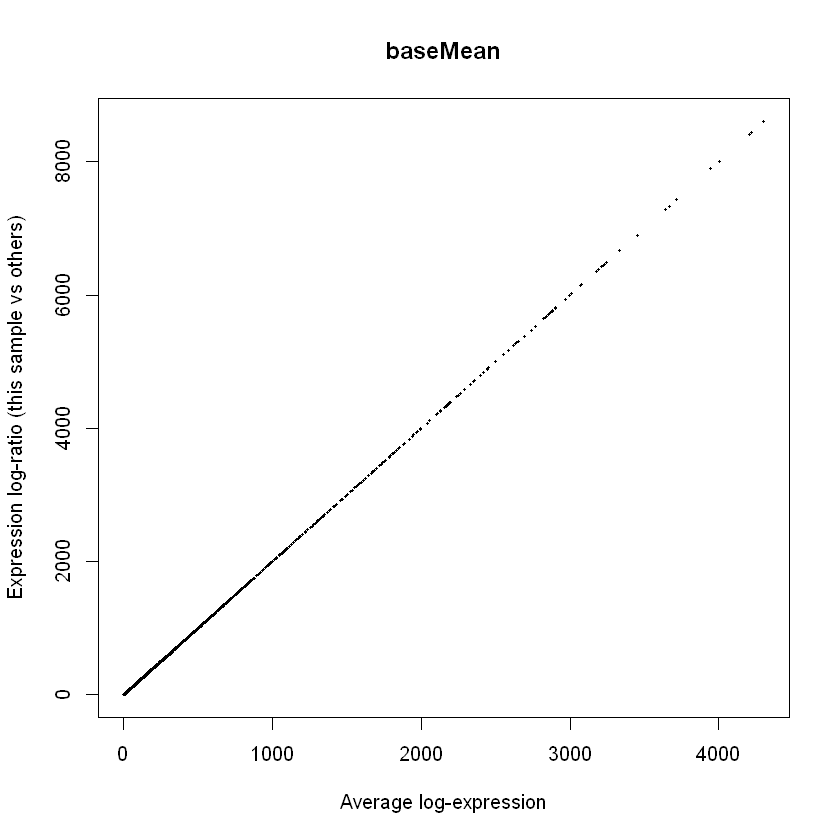

In [115]:
# MA plot
plotMA(res)

In [113]:
normCount <- read.csv("normal_propionibacterium_freudenreichii.csv", row.names = 1)
deSeqRes <- read.csv("deseq_propionibacterium_freudenreichii.csv", row.names = 1)
deSeqRes$sig <- ifelse(deSeqRes$padj <= 0.05, "yes", "no")
deSeqRes <- na.omit(deSeqRes)
deSeqRes

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
TPRN,1564.5107,1.805560,0.05790590,31.18093,1.932370e-213,2.592468e-209,yes
TUFT1,784.2995,2.596450,0.08959903,28.97855,1.226214e-184,8.225441e-181,yes
CHKA,631.8799,2.632206,0.09683661,27.18193,1.062331e-162,4.750746e-159,yes
NEU1,633.6624,2.247056,0.08631485,26.03325,2.082071e-149,6.983266e-146,yes
AREG,489.6559,2.460116,0.09685572,25.39980,2.534707e-142,6.801125e-139,yes
AGPAT2,1823.5832,1.295068,0.05255765,24.64091,4.606256e-134,1.029959e-130,yes
METRNL,613.9863,1.922115,0.07887515,24.36908,3.639324e-131,6.975024e-128,yes
EHD1,700.9916,1.805535,0.07450874,24.23253,1.010641e-129,1.694845e-126,yes
LMTK3,270.9993,2.947580,0.12313967,23.93689,1.265578e-126,1.886555e-123,yes


Gráfico de dispersión de log2FoldChange vs. log1O(baseMean):

Este gráfico te permite visualizar la relación entre la expresión media de los genes (log1O(baseMean)) y la diferencia de expresión entre condiciones (log2FoldChange). Los genes con una mayor diferencia de expresión y una mayor expresión media son más probables de ser importantes.

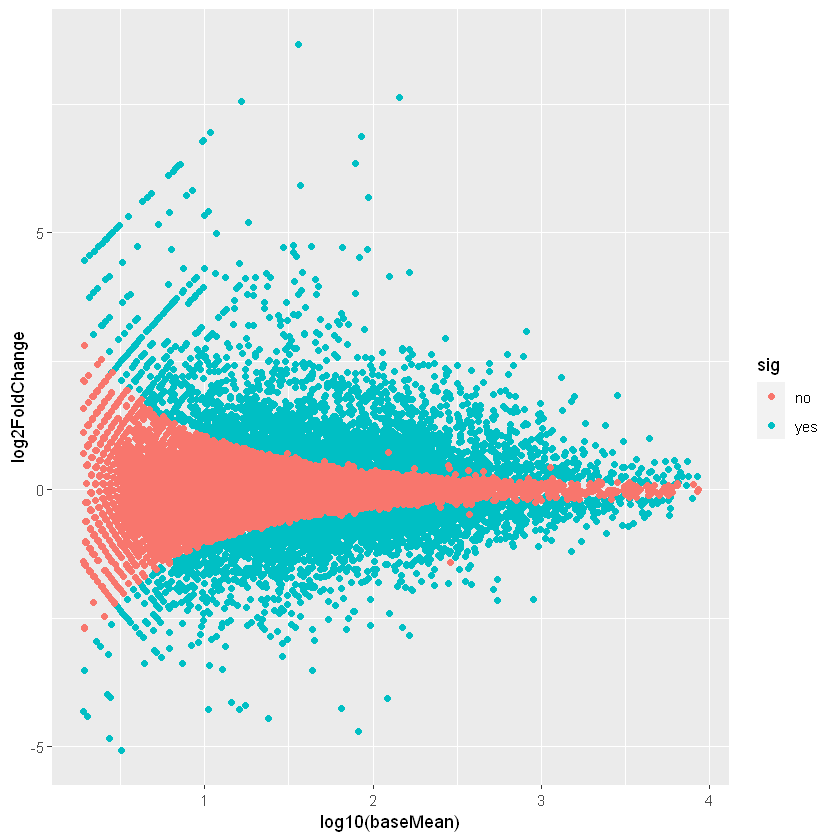

In [114]:
#Gráfico PlotMa
ggplot(deSeqRes, aes(x = log10(baseMean), y = log2FoldChange, color = sig)) + geom_point()

Gráfico de dispersión de log2FoldChange vs. p-value:

Este gráfico te permite visualizar la relación entre la diferencia de expresión y el nivel de significación (p-value). Los genes con una mayor diferencia de expresión y un p-value más bajo son más probables de ser importantes.

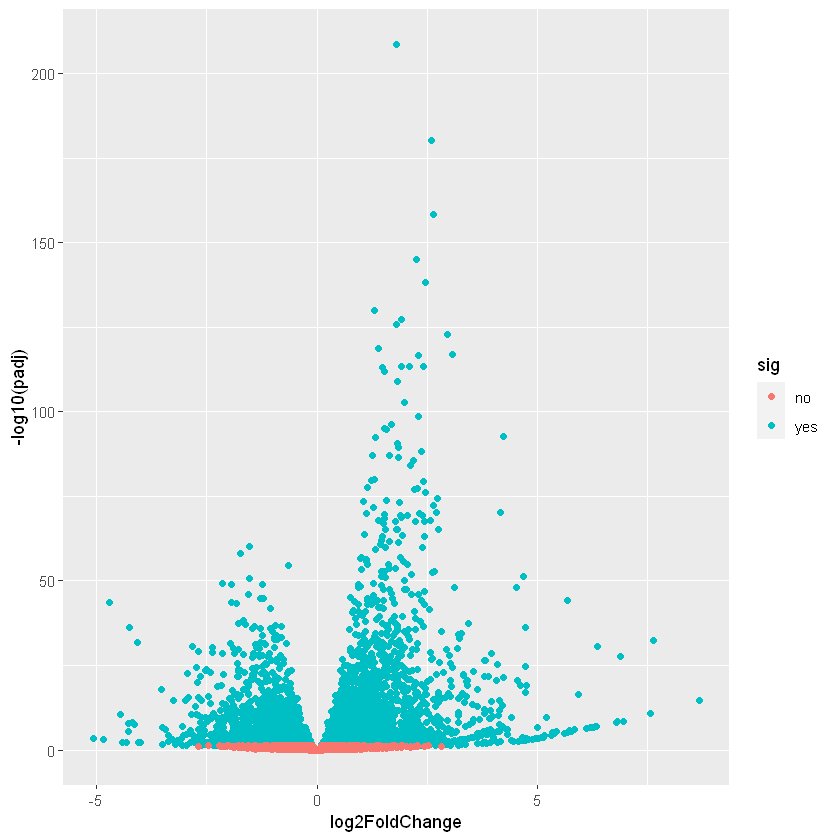

In [116]:
#volcano plot
ggplot(deSeqRes, aes(x = log2FoldChange, y = -log10(padj), color = sig)) + geom_point()

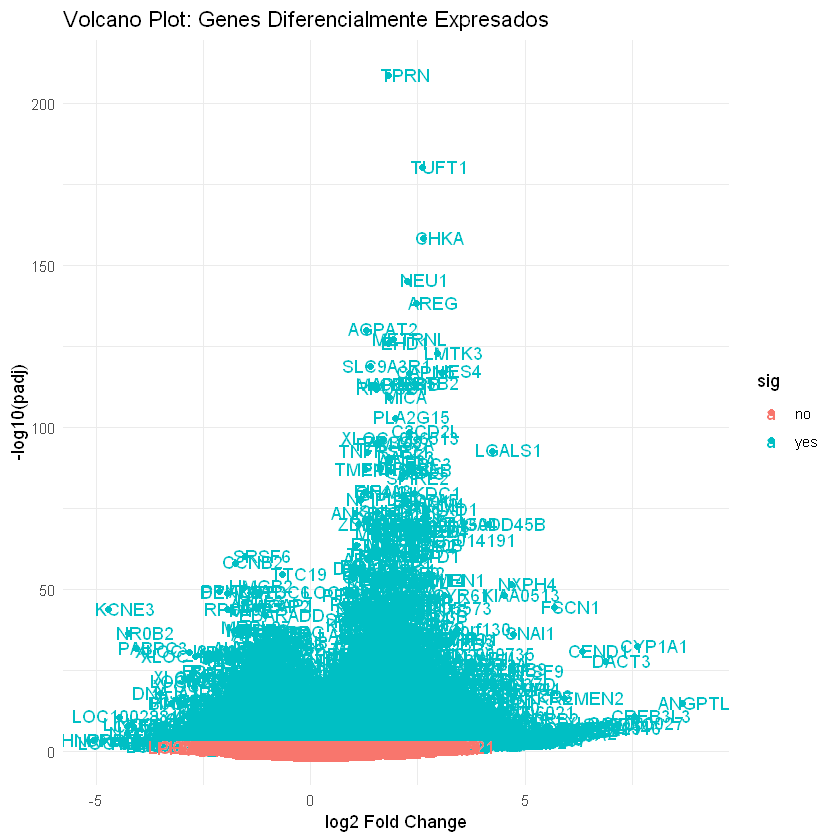

In [117]:
# Crea el gráfico de volcán con etiquetas de genes

ggplot(deSeqRes, aes(x = log2FoldChange, y = -log10(padj), color = sig)) +
  geom_point() +
  geom_text(aes(label = rownames(deSeqRes)), nudge_x = 0.4, nudge_y = 0.4) +  # Agrega las etiquetas
  labs(x = "log2 Fold Change", y = "-log10(padj)", title = "Volcano Plot: Genes Diferencialmente Expresados") +
  theme_minimal()

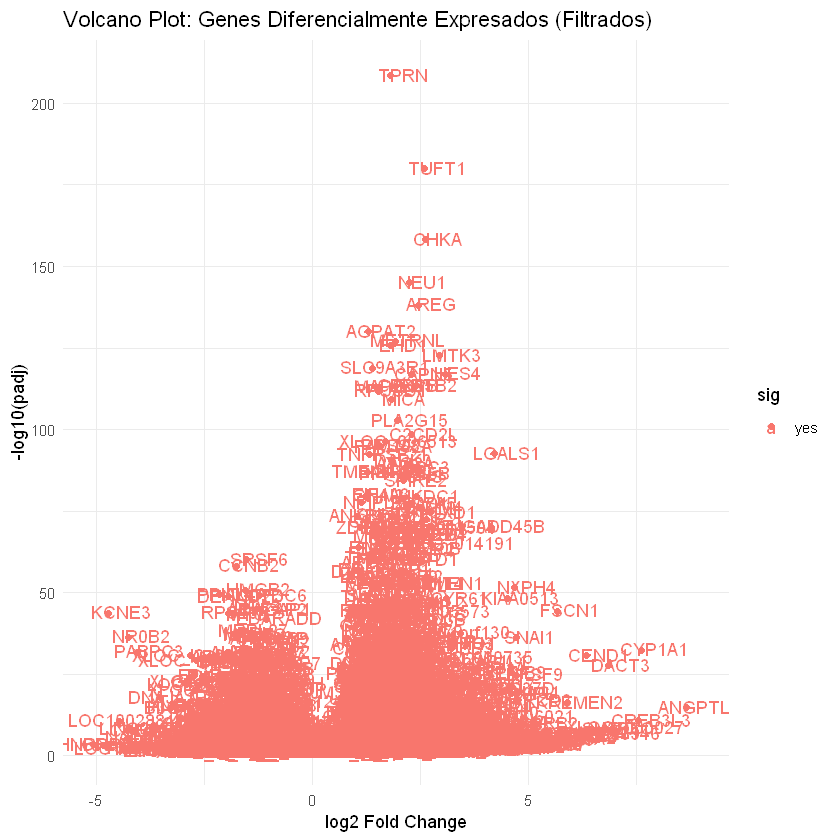

In [121]:
# Filtra los datos para incluir solo los genes significativos
umbral_pvalor <- 0.05
umbral_foldchange <- 2  # Por ejemplo, considera genes con un cambio de plegamiento mayor a 2

# Agrega una columna con los nombres de los genes
deSeqRes$gene_name <- row.names(deSeqRes)
deSeqRes_filtrado <- deSeqRes %>%
  filter(padj <= umbral_pvalor, abs(log2FoldChange) >= log2(umbral_foldchange))

# Crea el gráfico de volcán con los datos filtrados
library(ggplot2)
ggplot(deSeqRes_filtrado, aes(x = log2FoldChange, y = -log10(padj), color = sig)) +
  geom_point() +
  geom_text(aes(label = gene_name), nudge_x = 0.3, nudge_y = 0.4) +
  labs(x = "log2 Fold Change", y = "-log10(padj)", title = "Volcano Plot: Genes Diferencialmente Expresados (Filtrados)") +
  theme_minimal()
write.csv(deSeqRes_filtrado, "deSeqRes_filtrado_Propionibacterium freudenreichii.csv")

El gráfico de PCA permite visualizar la estructura de los datos y observar cómo se agrupan las muestras en función de su expresión génica. Las muestras con perfiles de expresión similares se agruparán cerca unas de otras en el gráfico. Esto es útil para:

Identificar patrones de agrupamiento: Ver si las muestras se agrupan de acuerdo con las condiciones experimentales, lo cual puede sugerir diferencias biológicas entre grupos.
Detectar muestras atípicas: Identificar muestras que no se agrupan con otras de su condición, lo cual podría indicar problemas técnicos o biológicos.
Explorar la variabilidad en los datos: Entender qué proporción de la variación total es explicada por los primeros componentes principales.

,HT-29 cells control sample-1,HT-29 cells control sample-2,HT-29 cells control sample-3,HT-29 cells control sample-4,HT-29 cells treatment sample-1,HT-29 cells treatment sample-2,HT-29 cells treatment sample-3,HT-29 cells treatment sample-4
HEBP1,6.3699221,6.3200433,6.1362820,6.114368,7.3786065,7.3863287,7.2666509,7.1293934
SNAR-G2,11.1569880,11.1311463,10.9052461,10.741069,9.9691623,10.1415621,9.7348307,9.5714849
LOC100506844,1.2398809,1.2373133,1.2328479,1.238340,1.2442761,1.2718394,1.2694716,1.2784914
CKLF,0.7795632,0.8980024,0.8901138,0.870792,0.7477176,0.7467047,0.7461914,0.7481469
MGST2,7.7165858,7.7826751,7.9192774,7.829162,7.1246975,7.1751737,7.1844553,7.1490722
CLK1,3.1236361,3.1931808,3.1252412,3.145326,3.1386506,3.0981549,3.1735376,3.1724424


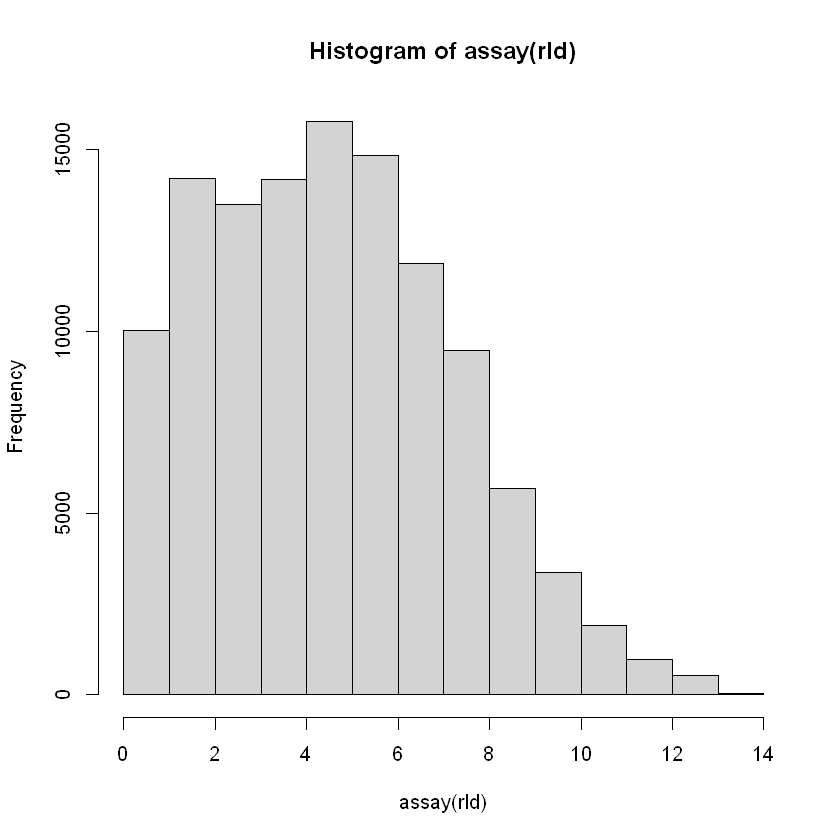

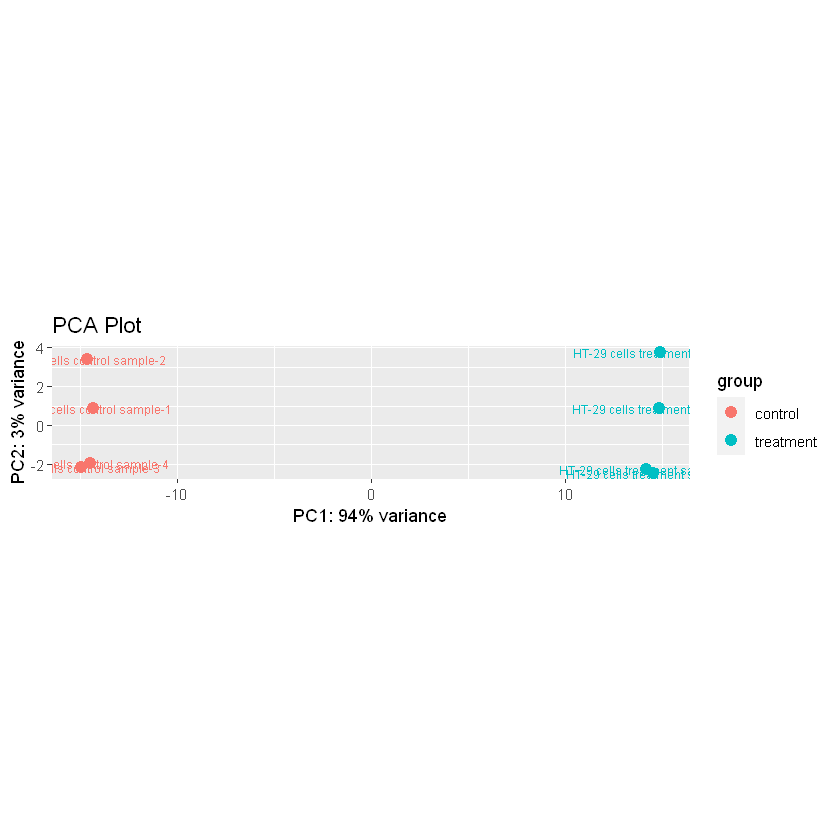

In [119]:
rld <- rlogTransformation(dds, blind = FALSE)
head(assay(rld))
hist(assay(rld))
PCAA <- plotPCA(rld, intgroup='condition')
PCAA + geom_text(aes(label = name),size = 2.5)+ggtitle('PCA Plot')

Este heatmap ayuda a visualizar y explorar los patrones de expresión de los genes significativamente diferenciados, permitiendo identificar grupos de genes que pueden estar coexpresados o que presentan patrones de expresión similares bajo diferentes condiciones experimentales. Es una herramienta útil para detectar patrones globales y potencialmente identificar genes o conjuntos de genes que podrían estar relacionados funcionalmente.

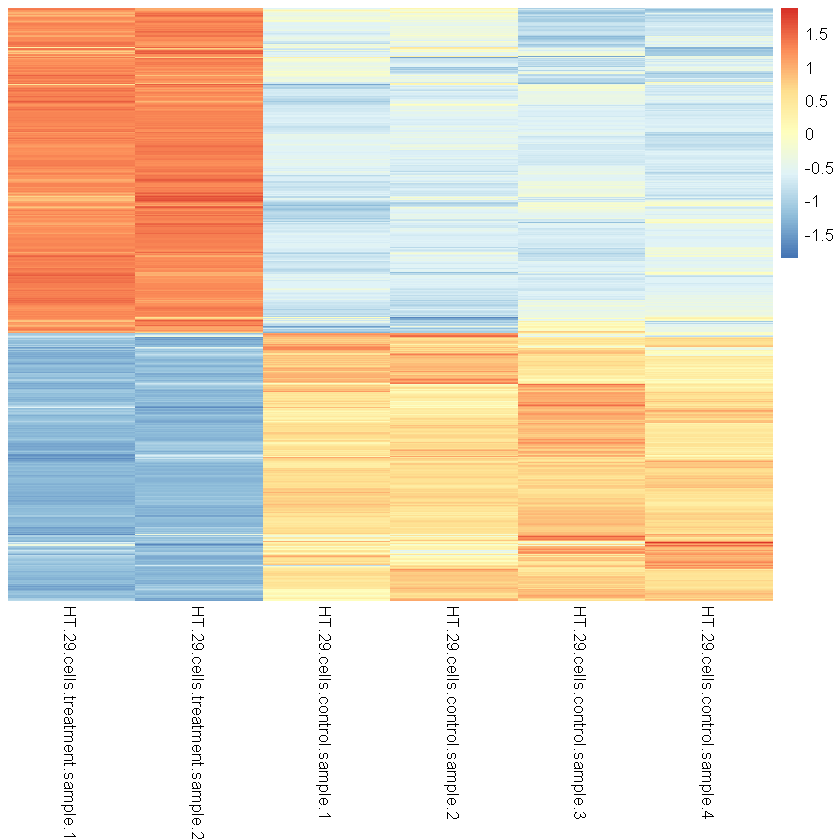

In [120]:
#pheatmap
signi <- subset(deSeqRes, padj <= 0.05)
allSig <- merge(normCount, signi, by = 0)
sigCounts <- allSig[,2:7]
row.names(sigCounts) <- allSig$Row.names
pheatmap(log2(sigCounts + 1), scale = 'row', show_rownames = F, treeheight_row = 0, treeheight_col = 0)

